# Exploración y visualización de datos

In [126]:
import os
import pandas as pd
import sys
sys.path.append(os.path.abspath(os.path.join('../..','iESPnet_SRC_main','utilities')))
from Generator import SeizureDatasetLabelTime, scale_spec, permute_spec, smoothing_label
from Model import iESPnet
from TrainEval import train_model_opt, test_model, train_model, get_thr_output, get_performance_indices
import IO
import Epochs
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import torchaudio.transforms as T
import numpy as np
import mne
mne.set_log_level(verbose='warning') #to avoid info at terminal
import matplotlib.pyplot as plt
import librosa
from scipy import fft as sp_fft
from matplotlib.backends.backend_pdf import PdfPages

# set the seed for reproducibility
torch.manual_seed(0)

## Meta data

In [225]:
meta_data_file = '/media/martin/Disco2/Rns_Data/PITT_PI_process/METADATA_process/allfiles_metadata.csv'
df_meta = pd.read_csv(meta_data_file)

In [226]:
# muestra la informacion del dataframe
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44223 entries, 0 to 44222
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rns_id  44223 non-null  object 
 1   data    44223 non-null  object 
 2   label   44223 non-null  int64  
 3   time    44223 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.3+ MB


In [227]:
# muestra los primeros 5 datos del dataframe 
df_meta.head()

,rns_id,data,label,time
0,PIT-RNS1603,PIT_RNS1603_20150804-1_E0,0,0.0
1,PIT-RNS1603,PIT_RNS1603_20150804-1_E1,0,0.0
2,PIT-RNS1603,PIT_RNS1603_20150804-1_E2,0,0.0
3,PIT-RNS1603,PIT_RNS1603_20150804-1_E3,0,0.0
4,PIT-RNS1603,PIT_RNS1603_20150804-1_E4,0,0.0


In [228]:
# muestra los ultimos 5 datos del dataframe 
df_meta.tail()

,rns_id,data,label,time
44218,PIT-RNS8076,PIT_RNS8076_20190806-1_E21,0,0.0
44219,PIT-RNS8076,PIT_RNS8076_20190806-1_E22,0,0.0
44220,PIT-RNS8076,PIT_RNS8076_20190806-1_E23,0,0.0
44221,PIT-RNS8076,PIT_RNS8076_20190806-1_E24,0,0.0
44222,PIT-RNS8076,PIT_RNS8076_20190806-1_E25,0,0.0


In [229]:
# muestra las columnas del dataframe, tambien pueden verse en el df.info()
df_meta.columns

Index(['rns_id', 'data', 'label', 'time'], dtype='object')

In [230]:
# muestra el tamaño del dataframe
df_meta.shape

(44223, 4)

In [231]:
# muestra el tipo de dato que hay en cada columna 
df_meta.dtypes

rns_id     object
data       object
label       int64
time      float64
dtype: object

In [232]:
# muestra el tipo de dato de df_meta
type(df_meta)

pandas.core.frame.DataFrame

In [233]:
# separación de variables 

variable_categorica = []
variable_numerica   = []

for columna in df_meta.columns:
    if df_meta[columna].dtypes == 'object':
        variable_categorica.append(columna)
    else:
        variable_numerica.append(columna)

print('Variable Categórica:', variable_categorica,'\n')
print('Variable Numérica:  ', variable_numerica)


Variable Categórica: ['rns_id', 'data'] 

Variable Numérica:   ['label', 'time']


In [234]:
# muestras los valores unicos 
df_meta['rns_id'].unique()

array(['PIT-RNS1603', 'PIT-RNS6989', 'PIT-RNS3016', 'PIT-RNS1529',
       'PIT-RNS7168', 'PIT-RNS4098', 'PIT-RNS1836', 'PIT-RNS9183',
       'PIT-RNS1440', 'PIT-RNS1713', 'PIT-RNS9536', 'PIT-RNS2543',
       'PIT-RNS1438', 'PIT-RNS1534', 'PIT-RNS9793', 'PIT-RNS1703',
       'PIT-RNS1556', 'PIT-RNS1597', 'PIT-RNS6992', 'PIT-RNS8326',
       'PIT-RNS2227', 'PIT-RNS8163', 'PIT-RNS4998', 'PIT-RNS8973',
       'PIT-RNS6806', 'PIT-RNS1090', 'PIT-RNS2368', 'PIT-RNS6762',
       'PIT-RNS2938', 'PIT-RNS7525', 'PIT-RNS0427', 'PIT-RNS8076'],
      dtype=object)

In [235]:
# muestra la cantidad de pacientes
len(df_meta['rns_id'].unique())
print('La cantidad de pacientes es:', len(df_meta['rns_id'].unique()))

La cantidad de pacientes es: 32


In [236]:
# se quiere hacer una lista con los id de los pacientes una unica vez
patients = df_meta['rns_id'].unique().tolist()
print(patients,'\n')
print('Se tienen los registros de {} pacientes'.format(len(patients)))

['PIT-RNS1603', 'PIT-RNS6989', 'PIT-RNS3016', 'PIT-RNS1529', 'PIT-RNS7168', 'PIT-RNS4098', 'PIT-RNS1836', 'PIT-RNS9183', 'PIT-RNS1440', 'PIT-RNS1713', 'PIT-RNS9536', 'PIT-RNS2543', 'PIT-RNS1438', 'PIT-RNS1534', 'PIT-RNS9793', 'PIT-RNS1703', 'PIT-RNS1556', 'PIT-RNS1597', 'PIT-RNS6992', 'PIT-RNS8326', 'PIT-RNS2227', 'PIT-RNS8163', 'PIT-RNS4998', 'PIT-RNS8973', 'PIT-RNS6806', 'PIT-RNS1090', 'PIT-RNS2368', 'PIT-RNS6762', 'PIT-RNS2938', 'PIT-RNS7525', 'PIT-RNS0427', 'PIT-RNS8076'] 

Se tienen los registros de 32 pacientes


In [237]:
df_meta['rns_id'].value_counts()

rns_id
PIT-RNS4098    3882
PIT-RNS1440    3077
PIT-RNS1836    2477
PIT-RNS1597    2477
PIT-RNS2368    2460
PIT-RNS1438    2147
PIT-RNS9536    1948
PIT-RNS2543    1839
PIT-RNS1603    1808
PIT-RNS4998    1628
PIT-RNS0427    1585
PIT-RNS6989    1569
PIT-RNS1090    1567
PIT-RNS8326    1512
PIT-RNS3016    1490
PIT-RNS1703    1471
PIT-RNS6806    1468
PIT-RNS1529    1255
PIT-RNS8973    1251
PIT-RNS2938    1103
PIT-RNS1534    1081
PIT-RNS6992     950
PIT-RNS8163     689
PIT-RNS1556     657
PIT-RNS8076     577
PIT-RNS7168     530
PIT-RNS2227     426
PIT-RNS9183     386
PIT-RNS7525     360
PIT-RNS6762     328
PIT-RNS1713     193
PIT-RNS9793      32
Name: count, dtype: int64

In [238]:
# a que se le asigno label=2
df_meta['label'].value_counts()

label
0    34681
1     9477
2       65
Name: count, dtype: int64

In [239]:
# se puede visualizar como el onset esta cercano a 0 segundos en estos casos
df_meta[df_meta['label']==2]

,rns_id,data,label,time
18130,PIT-RNS9536,PIT_RNS9536_20161215-1_E62,2,0.091463
19498,PIT-RNS2543,PIT_RNS2543_20200225-1_E71,2,0.114000
19499,PIT-RNS2543,PIT_RNS2543_20200225-1_E72,2,0.103000
19501,PIT-RNS2543,PIT_RNS2543_20200225-1_E74,2,0.089000
19502,PIT-RNS2543,PIT_RNS2543_20200225-1_E75,2,0.088000
...,...,...,...,...
27200,PIT-RNS1597,PIT_RNS1597_20161012-1_E371,2,0.101626
30976,PIT-RNS2227,PIT_RNS2227_20160811-1_E96,2,0.066683
31017,PIT-RNS2227,PIT_RNS2227_20161012-1_E8,2,0.077000
31079,PIT-RNS2227,PIT_RNS2227_20161012-1_E70,2,0.095203


In [240]:
# que papcientes tienen 2 en label
df_meta[df_meta['label']==2]['rns_id'].unique()

array(['PIT-RNS9536', 'PIT-RNS2543', 'PIT-RNS1597', 'PIT-RNS2227'],
      dtype=object)

In [241]:
# es importante saber el nombre del dato que tiene 2 en el label para poder limpiar directamente la base
registros_lipieza = df_meta[df_meta['label']==2]['data'].unique().tolist()
len(registros_lipieza)

65

In [242]:
# en este caso se visualiza que el onset esta en tiempos mayores a un segundo
df_meta[df_meta['label']==1]

,rns_id,data,label,time
95,PIT-RNS1603,PIT_RNS1603_20150909-1_E23,1,38.261325
119,PIT-RNS1603,PIT_RNS1603_20150909-1_E47,1,9.438130
159,PIT-RNS1603,PIT_RNS1603_20151021-1_E4,1,31.906845
170,PIT-RNS1603,PIT_RNS1603_20151021-1_E15,1,38.072439
178,PIT-RNS1603,PIT_RNS1603_20151021-1_E23,1,37.034439
...,...,...,...,...
44175,PIT-RNS8076,PIT_RNS8076_20160406-2_E24,1,21.743000
44176,PIT-RNS8076,PIT_RNS8076_20160406-2_E25,1,25.253000
44177,PIT-RNS8076,PIT_RNS8076_20160406-2_E26,1,24.033000
44178,PIT-RNS8076,PIT_RNS8076_20160406-2_E27,1,18.728000


In [243]:
# se hace un drop de los datos con label = 2
df_meta.drop(df_meta[df_meta['label'] == 2].index, inplace = True)
df_meta['label'].value_counts()

label
0    34681
1     9477
Name: count, dtype: int64

In [244]:
# muestra la cantidad de pacientes
len(df_meta['rns_id'].unique())
print('La cantidad de pacientes es:', len(df_meta['rns_id'].unique()))

La cantidad de pacientes es: 32


In [245]:
df_meta.groupby(['rns_id','label']).size().reset_index(name='counts')

,rns_id,label,counts
0,PIT-RNS0427,0,1316
1,PIT-RNS0427,1,269
2,PIT-RNS1090,0,1299
3,PIT-RNS1090,1,268
4,PIT-RNS1438,0,2122
...,...,...,...
58,PIT-RNS9183,0,266
59,PIT-RNS9183,1,120
60,PIT-RNS9536,0,1690
61,PIT-RNS9536,1,257


### Paciente PIT-RNS9793

In [246]:
df_meta[df_meta['rns_id']=='PIT-RNS9793'].head()

,rns_id,data,label,time
23682,PIT-RNS9793,PIT_RNS9793_20181010-1_E0,0,0.0
23683,PIT-RNS9793,PIT_RNS9793_20181010-1_E1,0,0.0
23684,PIT-RNS9793,PIT_RNS9793_20181010-1_E2,0,0.0
23685,PIT-RNS9793,PIT_RNS9793_20181010-1_E3,0,0.0
23686,PIT-RNS9793,PIT_RNS9793_20181010-1_E4,0,0.0


In [247]:
df_meta[df_meta['rns_id']=='PIT-RNS9793'].shape

(32, 4)

In [248]:
df_meta[df_meta['rns_id']=='PIT-RNS9793'][df_meta[df_meta['rns_id']=='PIT-RNS9793']['label']==0].shape

(32, 4)

In [249]:
df_meta[df_meta['rns_id']=='PIT-RNS9793'][df_meta[df_meta['rns_id']=='PIT-RNS9793']['label']==1].shape

(0, 4)

Como se puede visualizar el paciente PIT-RNS9793 no contiene ninguna anotación seizure, este paciente se va a sacar de la base de datos

In [250]:
len(df_meta[df_meta['rns_id']=='PIT-RNS9793']['data'].unique().tolist())

32

In [251]:
# es importante saber el nombre del dato que tiene 2 en el label para poder limpiar directamente la base
registros_lipieza.extend(df_meta[df_meta['rns_id']=='PIT-RNS9793']['data'].unique().tolist())
len(registros_lipieza)

97

In [252]:
print(df_meta[df_meta['rns_id']=='PIT-RNS9793'].shape)
df_meta.drop(df_meta[df_meta['rns_id']=='PIT-RNS9793'].index, inplace = True)

(32, 4)


In [253]:
# muestra la cantidad de pacientes
len(df_meta['rns_id'].unique())
print('La cantidad de pacientes es:', len(df_meta['rns_id'].unique()))

La cantidad de pacientes es: 31


### Paciente PIT-RNS4998

In [254]:
df_meta[df_meta['rns_id']=='PIT-RNS4998'].head()

,rns_id,data,label,time
31896,PIT-RNS4998,PIT_RNS4998_20190604-1_E0,1,38.671
31897,PIT-RNS4998,PIT_RNS4998_20190604-1_E1,0,0.000
31898,PIT-RNS4998,PIT_RNS4998_20190604-1_E2,0,0.000
31899,PIT-RNS4998,PIT_RNS4998_20190604-1_E3,0,0.000
31900,PIT-RNS4998,PIT_RNS4998_20190604-1_E4,0,0.000


In [255]:
df_meta[df_meta['rns_id']=='PIT-RNS4998'].shape

(1628, 4)

In [256]:
df_meta[df_meta['rns_id']=='PIT-RNS4998'][df_meta[df_meta['rns_id']=='PIT-RNS4998']['label']==0].shape

(1627, 4)

In [257]:
df_meta[df_meta['rns_id']=='PIT-RNS4998'][df_meta[df_meta['rns_id']=='PIT-RNS4998']['label']==1].shape

(1, 4)

In [259]:
len(df_meta[df_meta['rns_id']=='PIT-RNS4998']['data'].unique().tolist())

1628

In [260]:
# es importante saber el nombre del dato que tiene 2 en el label para poder limpiar directamente la base
registros_lipieza.extend(df_meta[df_meta['rns_id']=='PIT-RNS4998']['data'].unique().tolist())
len(registros_lipieza)

1725

In [261]:
print(df_meta[df_meta['rns_id']=='PIT-RNS4998'].shape)
df_meta.drop(df_meta[df_meta['rns_id']=='PIT-RNS4998'].index, inplace = True)

(1628, 4)


In [262]:
# muestra la cantidad de pacientes
len(df_meta['rns_id'].unique())
print('La cantidad de pacientes es:', len(df_meta['rns_id'].unique()))

La cantidad de pacientes es: 30


In [263]:
print(registros_lipieza)

['PIT_RNS9536_20161215-1_E62', 'PIT_RNS2543_20200225-1_E71', 'PIT_RNS2543_20200225-1_E72', 'PIT_RNS2543_20200225-1_E74', 'PIT_RNS2543_20200225-1_E75', 'PIT_RNS2543_20200225-1_E76', 'PIT_RNS2543_20200805-1_E179', 'PIT_RNS2543_20200805-1_E202', 'PIT_RNS2543_20200805-1_E229', 'PIT_RNS2543_20200805-1_E264', 'PIT_RNS2543_20201103-1_E16', 'PIT_RNS2543_20201103-1_E115', 'PIT_RNS2543_20201103-1_E147', 'PIT_RNS2543_20201103-1_E193', 'PIT_RNS2543_20201103-1_E287', 'PIT_RNS2543_20201103-1_E292', 'PIT_RNS2543_20201103-1_E297', 'PIT_RNS1597_20160120-1_E30', 'PIT_RNS1597_20160120-1_E44', 'PIT_RNS1597_20160120-1_E78', 'PIT_RNS1597_20160120-1_E99', 'PIT_RNS1597_20160120-1_E130', 'PIT_RNS1597_20160120-1_E142', 'PIT_RNS1597_20160120-1_E204', 'PIT_RNS1597_20160120-1_E238', 'PIT_RNS1597_20160120-1_E245', 'PIT_RNS1597_20160406-1_E19', 'PIT_RNS1597_20160406-1_E83', 'PIT_RNS1597_20160406-1_E118', 'PIT_RNS1597_20160406-1_E153', 'PIT_RNS1597_20160406-1_E216', 'PIT_RNS1597_20160406-1_E224', 'PIT_RNS1597_2016040

### Los pacientes que tienen implante en talamo: ['PIT-RNS0427' 'PIT-RNS1713' 'PIT-RNS3016' 'PIT-RNS7168' 'PIT-RNS8326'] 

Los pacientes que tienen implante mixto y uno de ellos es talamo: ['PIT-RNS6762']

In [86]:
df_meta.drop(df_meta[df_meta['rns_id'].isin(['PIT-RNS0427', 'PIT-RNS1713', 'PIT-RNS3016','PIT-RNS7168','PIT-RNS8326', 'PIT-RNS6762'])].index, inplace = True)

In [87]:
# muestra la cantidad de pacientes
len(df_meta['rns_id'].unique())
print('La cantidad de pacientes es:', len(df_meta['rns_id'].unique()))

La cantidad de pacientes es: 25


In [24]:
df_meta.shape

(38488, 4)

## Meta data subjects


In [38]:
data_subjects = '/media/martin/Disco2/Rns_Data/subjects_info_nopadall.csv'
df_subjects = pd.read_csv(data_subjects)

In [39]:
df_subjects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   rns_deid_id              32 non-null     object
 1   ID                       31 non-null     object
 2   Gender                   32 non-null     object
 3   underlying_tissue_lead1  31 non-null     object
 4   underlying_tissue_lead2  31 non-null     object
 5   Group                    31 non-null     object
 6   Nfiles                   32 non-null     int64 
 7   Nsz                      32 non-null     int64 
dtypes: int64(2), object(6)
memory usage: 2.1+ KB


In [40]:
df_subjects.shape

(32, 8)

In [41]:
df_subjects.head()

,rns_deid_id,ID,Gender,underlying_tissue_lead1,underlying_tissue_lead2,Group,Nfiles,Nsz
0,RNS0427,EP1193,F,LCM - left thalamus (depth),RCM - right thalamus (depth),Thalamus,1496,279
1,RNS1090,EP1134,M,A - right heterotopia (depth),B - right heterotopia (depth),Migrational Dysplasia (Heterotopia/PMG),1576,270
2,RNS1438,EP1175,M,LHip - left hippocampus (depth),Lins - left insula (depth),Mixed Hippocampus - Neocortex,2409,25
3,RNS1440,EP1071,F,D - basal temporal (depth),S - temporo-occipital (strip),Neocortex,3102,799
4,RNS1529,EP1127,F,LHD - left hippocampus (depth),RHD - right hippocampus (depth),Hippocampus,1315,440


In [42]:
df_subjects.Group.unique()

array(['Thalamus', 'Migrational Dysplasia (Heterotopia/PMG)',
       'Mixed Hippocampus - Neocortex', 'Neocortex', 'Hippocampus',
       'Neocortical', 'Mixed Thalamus - Neocortex', nan], dtype=object)

['PIT-RNS0427' 'PIT-RNS1713' 'PIT-RNS3016' 'PIT-RNS7168' 'PIT-RNS8326']


In [43]:
print(df_subjects[df_subjects['Group']=='Thalamus']['rns_deid_id'].unique())

['RNS0427' 'RNS1713' 'RNS3016' 'RNS7168' 'RNS8326']


In [44]:
print(df_subjects[df_subjects['Group']=='Mixed Thalamus - Neocortex']['rns_deid_id'].unique())

['RNS6762']


In [46]:
df_subjects.Group.value_counts()

Group
Neocortex                                  9
Hippocampus                                8
Thalamus                                   5
Migrational Dysplasia (Heterotopia/PMG)    4
Mixed Hippocampus - Neocortex              3
Neocortical                                1
Mixed Thalamus - Neocortex                 1
Name: count, dtype: int64

Quiero conocer el paciente que sobra : PIT-RNS4998

In [48]:
df_subjects[df_subjects['rns_deid_id']=='RNS4998']

,rns_deid_id,ID,Gender,underlying_tissue_lead1,underlying_tissue_lead2,Group,Nfiles,Nsz
18,RNS4998,NaN,F,Lhip - left hippocampus (depth),Rhip - right hippocampus (depth),Hippocampus,1817,1


## Datos

In [184]:
# direccion de donde se encuentran los espectrogramas
SPE_DIR  = '/media/martin/Disco2/Rns_Data/PITT_PI_noprocess/'

In [185]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44126 entries, 0 to 44222
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rns_id  44126 non-null  object 
 1   data    44126 non-null  object 
 2   label   44126 non-null  int64  
 3   time    44126 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.7+ MB


In [186]:
len(df_meta.rns_id)

44126

In [187]:
# separación de datos de entrenamiento y testeo

s=0 # es el paciente que se deja afuera para el entrenamiento

train_df = df_meta.copy()
test_df  = df_meta[df_meta['rns_id'] == patients[s]]
test_df.reset_index(drop=True, inplace=True)
train_df.drop(train_df[train_df['rns_id'] == patients[s]].index, inplace = True)

In [188]:
# información de los datos de entrenamiento
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42318 entries, 1808 to 44222
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rns_id  42318 non-null  object 
 1   data    42318 non-null  object 
 2   label   42318 non-null  int64  
 3   time    42318 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.6+ MB


In [189]:
# cantidad de pacientes del grupo de entrenamiento 
len(train_df.rns_id.unique())

30

In [190]:
# información de los datos de test 
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1808 entries, 0 to 1807
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rns_id  1808 non-null   object 
 1   data    1808 non-null   object 
 2   label   1808 non-null   int64  
 3   time    1808 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 56.6+ KB


In [191]:
# cantidad de pacientes del grupo de test 
len(test_df.rns_id.unique())

1

### Visualizacion de espectrograma

Se quiere visualizar los 4 canales de un registro que no tenga seizure y los 4 canales de un registro que tenga seizure

In [192]:
df_meta.data[0]

'PIT_RNS1603_20150804-1_E0'

Se van a buscar dos registros distintos con y sin seizure

In [193]:
# valor que tiene la columna "data" del primer registro que en la columna "label" tenga el valor de 1
df_filt_1 = df_meta[df_meta['label'] == 1]
data_path_1 = df_filt_1['data'].iloc[0]

df_meta[df_meta.data == data_path_1]


,rns_id,data,label,time
95,PIT-RNS1603,PIT_RNS1603_20150909-1_E23,1,38.261325


In [194]:
# valor que tiene la columna "data" del primer registro que en la columna "label" tenga el valor de 1
df_filt_2 = df_meta[df_meta['label'] == 0]
data_path_2 = df_filt_2['data'].iloc[0]

df_meta[df_meta.data == data_path_2] 

,rns_id,data,label,time
0,PIT-RNS1603,PIT_RNS1603_20150804-1_E0,0,0.0


In [195]:
# se guarda la ruta de los archivos numpy
file_name_1 = SPE_DIR + data_path_1 + '.npy'
file_name_2 = SPE_DIR + data_path_2 + '.npy'

In [196]:
# se carga el archivo serializado numpy 1
dat_np_1 = np.load(file_name_1, allow_pickle=True)
dat_np_arr_1 = dat_np_1.item().get("spectrogram")
dat_np_arr_1.shape

(4, 120, 181)

In [197]:
# se carga el archivo serializado numpy 2
dat_np_2 = np.load(file_name_2, allow_pickle=True)
dat_np_arr_2 = dat_np_2.item().get("spectrogram")
dat_np_arr_2.shape

(4, 120, 181)

In [198]:
file_name_3 = SPE_DIR + 'PIT_RNS1713_20190226-1_E48' + '.npy'

# se carga el archivo serializado numpy 3
dat_np_3 = np.load(file_name_3, allow_pickle=True)
dat_np_arr_3 = dat_np_3.item().get("spectrogram")
dat_np_arr_3.shape

(4, 120, 181)

In [199]:
df_meta[df_meta['rns_id']=='PIT-RNS1713']

,rns_id,data,label,time
16474,PIT-RNS1713,PIT_RNS1713_20180308-1_E0,0,0.000000
16475,PIT-RNS1713,PIT_RNS1713_20180308-1_E1,0,0.000000
16476,PIT-RNS1713,PIT_RNS1713_20180308-1_E2,1,30.821635
16477,PIT-RNS1713,PIT_RNS1713_20180308-1_E3,1,46.618532
16478,PIT-RNS1713,PIT_RNS1713_20180308-1_E4,1,40.561783
...,...,...,...,...
16662,PIT-RNS1713,PIT_RNS1713_20190226-1_E45,0,0.000000
16663,PIT-RNS1713,PIT_RNS1713_20190226-1_E46,0,0.000000
16664,PIT-RNS1713,PIT_RNS1713_20190226-1_E47,0,0.000000
16665,PIT-RNS1713,PIT_RNS1713_20190226-1_E48,1,49.404000


In [200]:
df_filt_2 

,rns_id,data,label,time
0,PIT-RNS1603,PIT_RNS1603_20150804-1_E0,0,0.0
1,PIT-RNS1603,PIT_RNS1603_20150804-1_E1,0,0.0
2,PIT-RNS1603,PIT_RNS1603_20150804-1_E2,0,0.0
3,PIT-RNS1603,PIT_RNS1603_20150804-1_E3,0,0.0
4,PIT-RNS1603,PIT_RNS1603_20150804-1_E4,0,0.0
...,...,...,...,...
44218,PIT-RNS8076,PIT_RNS8076_20190806-1_E21,0,0.0
44219,PIT-RNS8076,PIT_RNS8076_20190806-1_E22,0,0.0
44220,PIT-RNS8076,PIT_RNS8076_20190806-1_E23,0,0.0
44221,PIT-RNS8076,PIT_RNS8076_20190806-1_E24,0,0.0


In [201]:
# visualicación de a un canal
'''plt.figure(figsize=(6, 3))
plt.imshow(dat_np_arr[0, :, : ], aspect="auto")
plt.gca().invert_yaxis()
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Input Spectrogram")
plt.show()'''

'plt.figure(figsize=(6, 3))\nplt.imshow(dat_np_arr[0, :, : ], aspect="auto")\nplt.gca().invert_yaxis()\nplt.xlabel("Time [s]")\nplt.ylabel("Frequency [Hz]")\nplt.title("Input Spectrogram")\nplt.show()'

Espectrogramas con seizure 

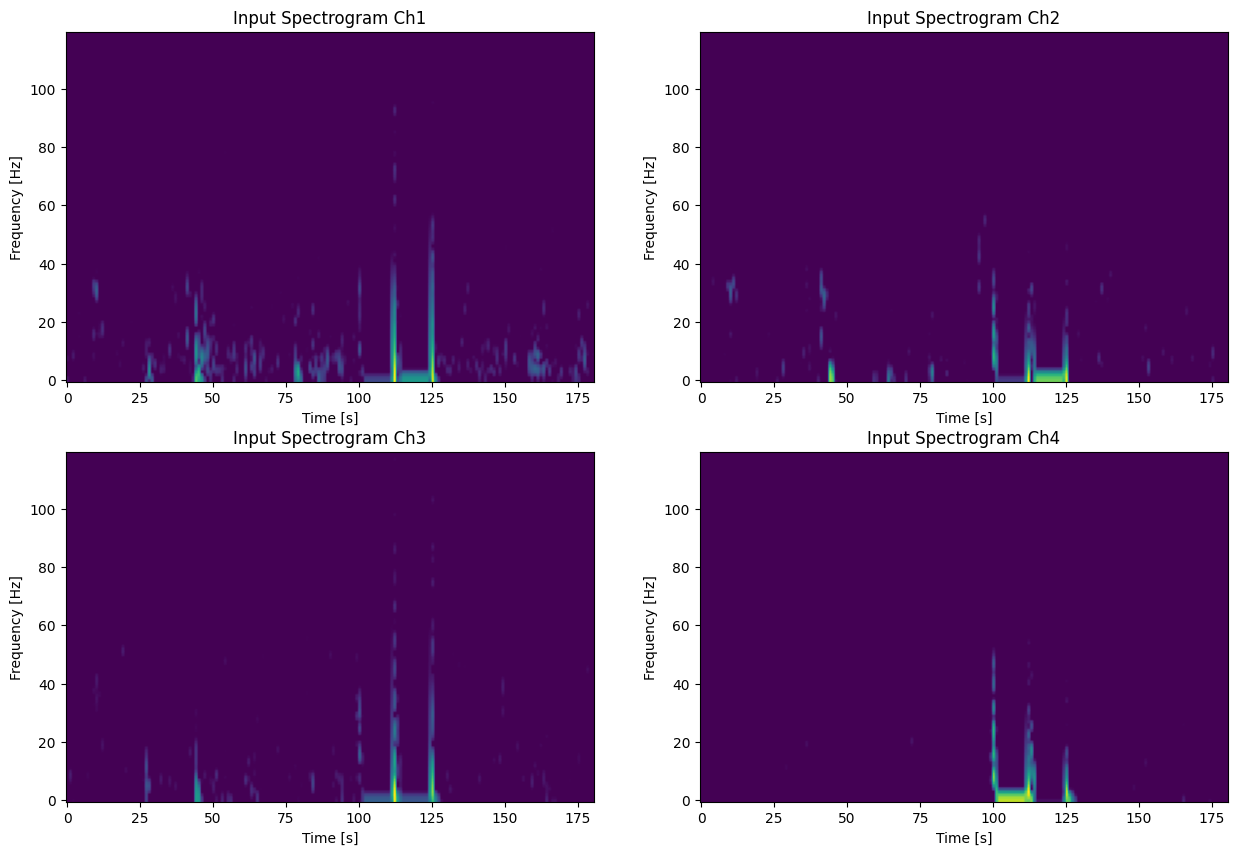

In [202]:
# visualización de los 4 canales juntos de dato con seizure
fig,axs = plt.subplots(2, 2, figsize = (15,10))

# Canal 1
axs[0,0].imshow(dat_np_arr_3[0, :, : ], aspect="auto")
axs[0,0].invert_yaxis()
axs[0,0].set_title("Input Spectrogram Ch1")
axs[0,0].set_ylabel("Frequency [Hz]")
axs[0,0].set_xlabel("Time [s]")

# Canal 2
axs[0,1].imshow(dat_np_arr_3[1, :, : ], aspect="auto")
axs[0,1].invert_yaxis()
axs[0,1].set_title("Input Spectrogram Ch2")
axs[0,1].set_ylabel("Frequency [Hz]")
axs[0,1].set_xlabel("Time [s]")

# Canal 3
axs[1,0].imshow(dat_np_arr_3[2, :, : ], aspect="auto")
axs[1,0].invert_yaxis()
axs[1,0].set_title("Input Spectrogram Ch3")
axs[1,0].set_ylabel("Frequency [Hz]")
axs[1,0].set_xlabel("Time [s]")

# Canal 4
axs[1,1].imshow(dat_np_arr_3[3, :, : ], aspect="auto")
axs[1,1].invert_yaxis()
axs[1,1].set_title("Input Spectrogram Ch4")
axs[1,1].set_ylabel("Frequency [Hz]")
axs[1,1].set_xlabel("Time [s]")

plt.show()


Espectrogramas sin seizure 

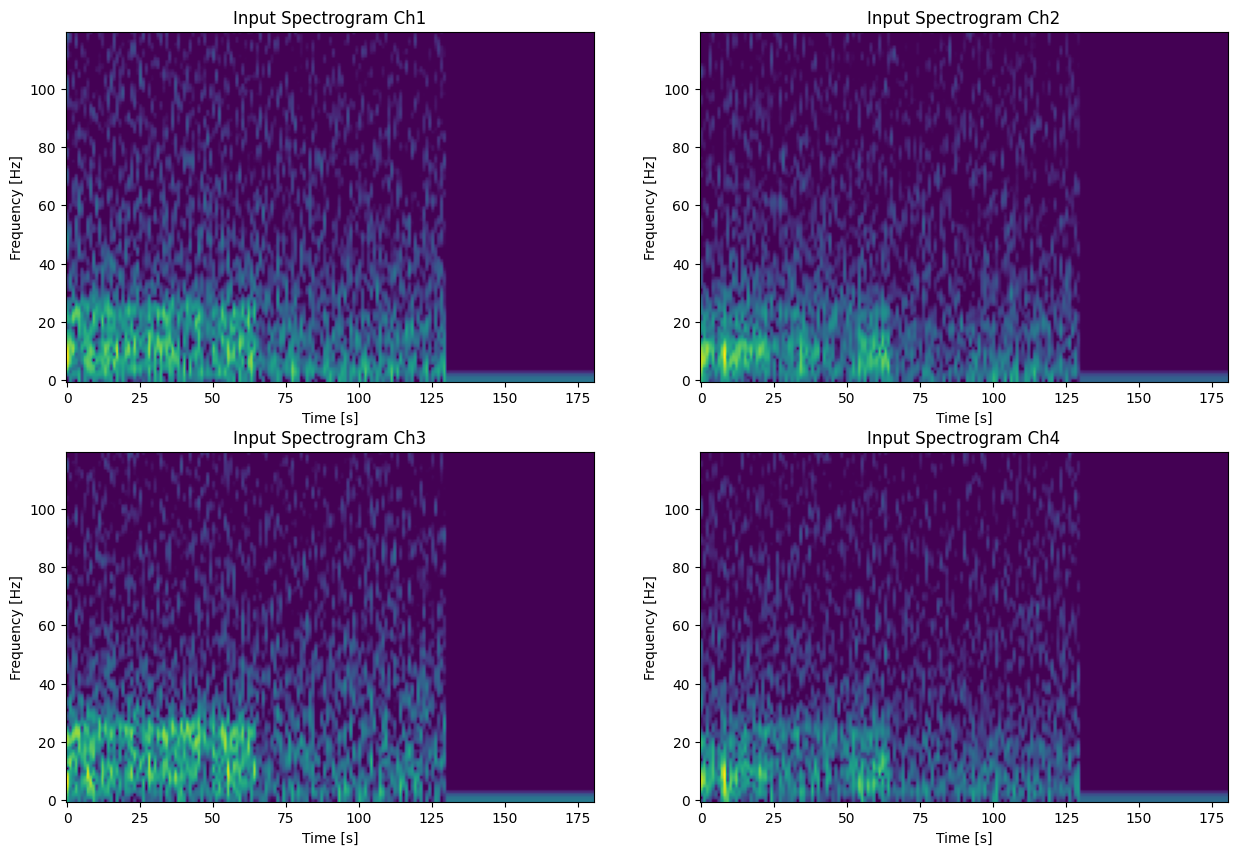

In [36]:
# visualización de los 4 canales juntos de dato sin seizure
fig,axs = plt.subplots(2, 2, figsize = (15,10))

# Canal 1
axs[0,0].imshow(dat_np_arr_2[0, :, : ], aspect="auto")
axs[0,0].invert_yaxis()
axs[0,0].set_title("Input Spectrogram Ch1")
axs[0,0].set_ylabel("Frequency [Hz]")
axs[0,0].set_xlabel("Time [s]")

# Canal 2
axs[0,1].imshow(dat_np_arr_2[1, :, : ], aspect="auto")
axs[0,1].invert_yaxis()
axs[0,1].set_title("Input Spectrogram Ch2")
axs[0,1].set_ylabel("Frequency [Hz]")
axs[0,1].set_xlabel("Time [s]")

# Canal 3
axs[1,0].imshow(dat_np_arr_2[2, :, : ], aspect="auto")
axs[1,0].invert_yaxis()
axs[1,0].set_title("Input Spectrogram Ch3")
axs[1,0].set_ylabel("Frequency [Hz]")
axs[1,0].set_xlabel("Time [s]")

# Canal 4
axs[1,1].imshow(dat_np_arr_2[3, :, : ], aspect="auto")
axs[1,1].invert_yaxis()
axs[1,1].set_title("Input Spectrogram Ch4")
axs[1,1].set_ylabel("Frequency [Hz]")
axs[1,1].set_xlabel("Time [s]")

plt.show()

In [37]:
# para visualizar el label primero realizaremos la transformacion con smoothing label: clase para transformar el label a continuo
class smoothing_label(object):
    def __call__(self, label, n=5, std=2.5):
        """"apply label smoothing."""
        label_time_smooth = label.copy()
        # for idx in range(len(label)):
        leng = len(label)
        idx_t = np.where(label==1)[0]
        
        if len(idx_t)!=0:
            if leng  - idx_t < n:
                n = leng  - idx_t
                aux = np.arange(idx_t-n,idx_t+n,1)
            elif idx_t - n < 0 : # in the very begining
                n = n + (idx_t - n)
                aux = np.arange(idx_t-n,idx_t+n,1)
            else:
                aux = np.arange(idx_t-n,idx_t+n,1)
                
            if aux.size!=0:                
                gaus =np.exp(-np.power(aux - idx_t, 2.) / (2 * np.power(std, 2.)))
                label_time_smooth[aux] = gaus
            else:
                label_time_smooth[idx_t] = 1
        return label_time_smooth

In [38]:
label_1 = dat_np_1.item().get('label')
target_transform_1 = smoothing_label()
label_1=target_transform_1(label_1)

label_2 = dat_np_2.item().get('label')
target_transform_2 = smoothing_label()
label_2=target_transform_2(label_2)

print()

/tmp/ipykernel_31792/2168213746.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  aux = np.arange(idx_t-n,idx_t+n,1)


Espectrogramas con seizure 

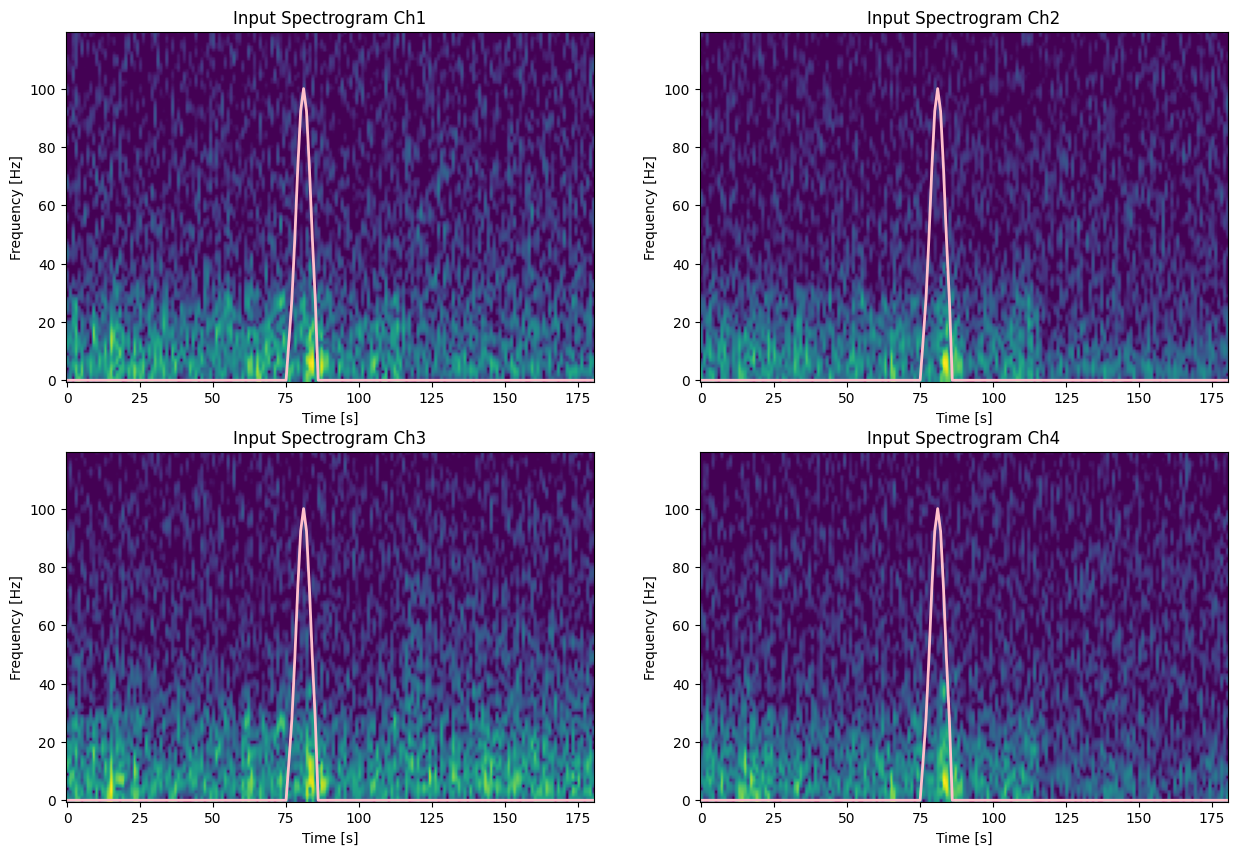

In [39]:
# visualización de los 4 canales juntos de dato con seizure
fig,axs = plt.subplots(2, 2, figsize = (15,10))

# Canal 1
axs[0,0].imshow(dat_np_arr_1[0, :, : ], aspect="auto")
axs[0,0].plot(label_1*100, color='pink', linewidth=2) # se multiplica por 100 para que se visualice?
axs[0,0].invert_yaxis()
axs[0,0].set_title("Input Spectrogram Ch1")
axs[0,0].set_ylabel("Frequency [Hz]")
axs[0,0].set_xlabel("Time [s]")

# Canal 2
axs[0,1].imshow(dat_np_arr_1[1, :, : ], aspect="auto")
axs[0,1].plot(label_1*100, color='pink', linewidth=2) # se multiplica por 100 para que se visualice?
axs[0,1].invert_yaxis()
axs[0,1].set_title("Input Spectrogram Ch2")
axs[0,1].set_ylabel("Frequency [Hz]")
axs[0,1].set_xlabel("Time [s]")

# Canal 3
axs[1,0].imshow(dat_np_arr_1[2, :, : ], aspect="auto")
axs[1,0].plot(label_1*100, color='pink', linewidth=2) # se multiplica por 100 para que se visualice?
axs[1,0].invert_yaxis()
axs[1,0].set_title("Input Spectrogram Ch3")
axs[1,0].set_ylabel("Frequency [Hz]")
axs[1,0].set_xlabel("Time [s]")

# Canal 4
axs[1,1].imshow(dat_np_arr_1[3, :, : ], aspect="auto")
axs[1,1].plot(label_1*100, color='pink', linewidth=2) # se multiplica por 100 para que se visualice?
axs[1,1].invert_yaxis()
axs[1,1].set_title("Input Spectrogram Ch4")
axs[1,1].set_ylabel("Frequency [Hz]")
axs[1,1].set_xlabel("Time [s]")

plt.show()

Espectrogramas sin seizure

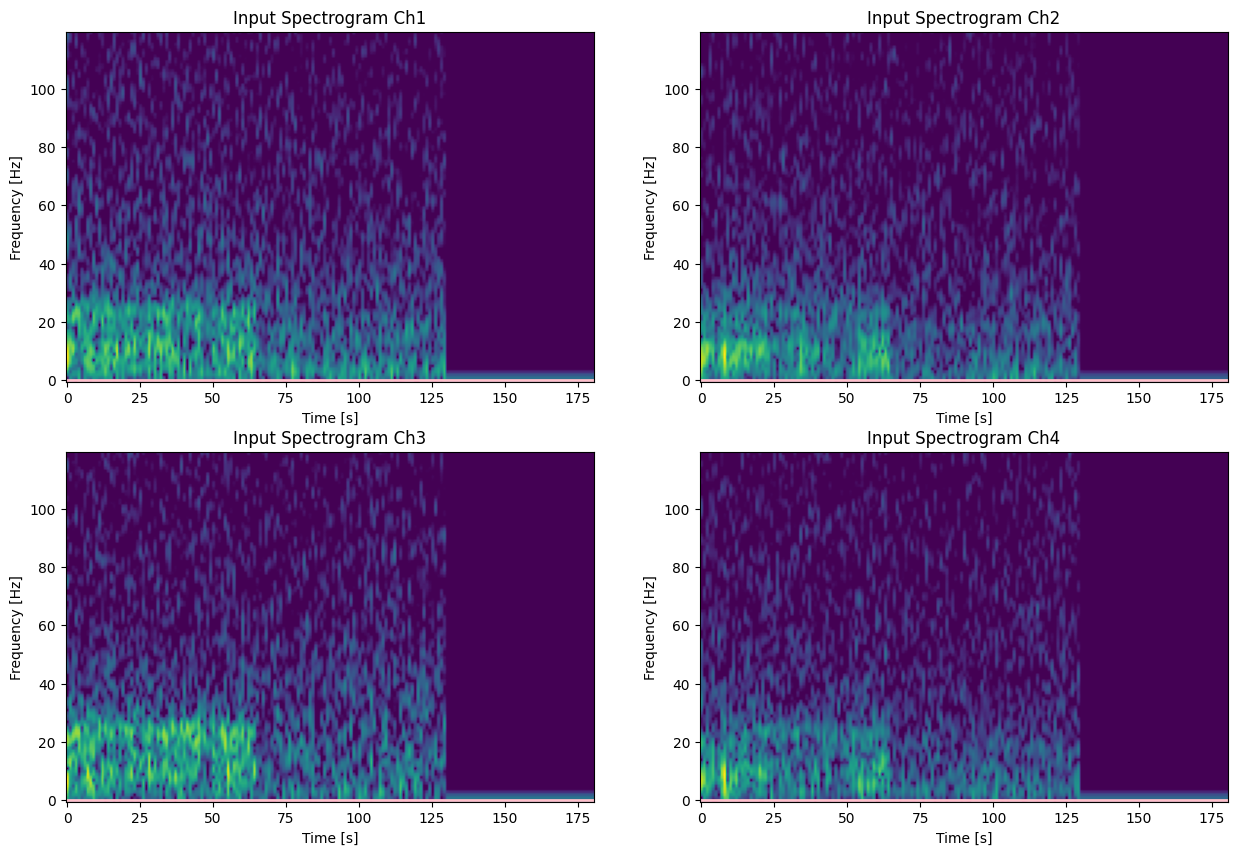

In [40]:
# visualización de los 4 canales juntos de dato sin seizure
fig,axs = plt.subplots(2, 2, figsize = (15,10))

# Canal 1
axs[0,0].imshow(dat_np_arr_2[0, :, : ], aspect="auto")
axs[0,0].plot(label_2*100, color='pink', linewidth=2) # se multiplica por 100 para que se visualice?
axs[0,0].invert_yaxis()
axs[0,0].set_title("Input Spectrogram Ch1")
axs[0,0].set_ylabel("Frequency [Hz]")
axs[0,0].set_xlabel("Time [s]")

# Canal 2
axs[0,1].imshow(dat_np_arr_2[1, :, : ], aspect="auto")
axs[0,1].plot(label_2*100, color='pink', linewidth=2) # se multiplica por 100 para que se visualice?
axs[0,1].invert_yaxis()
axs[0,1].set_title("Input Spectrogram Ch2")
axs[0,1].set_ylabel("Frequency [Hz]")
axs[0,1].set_xlabel("Time [s]")

# Canal 3
axs[1,0].imshow(dat_np_arr_2[2, :, : ], aspect="auto")
axs[1,0].plot(label_2*100, color='pink', linewidth=2) # se multiplica por 100 para que se visualice?
axs[1,0].invert_yaxis()
axs[1,0].set_title("Input Spectrogram Ch3")
axs[1,0].set_ylabel("Frequency [Hz]")
axs[1,0].set_xlabel("Time [s]")

# Canal 4
axs[1,1].imshow(dat_np_arr_2[3, :, : ], aspect="auto")
axs[1,1].plot(label_2*100, color='pink', linewidth=2) # se multiplica por 100 para que se visualice?
axs[1,1].invert_yaxis()
axs[1,1].set_title("Input Spectrogram Ch4")
axs[1,1].set_ylabel("Frequency [Hz]")
axs[1,1].set_xlabel("Time [s]")

plt.show()

### Continuación de train y test: preparación de los datos

In [41]:
# directorio en el cual se va a guardar el modelo
save_path        = 'SAVEPATH/'
save_runs        = save_path + patients[s] + '/runs/'
save_models      = save_path + patients[s] + '/models/'
save_predictions = save_path + patients[s] + '/results/'
save_figs        = save_path + patients[s] + '/figs/'

if not os.path.exists(save_path):
    os.makedirs(save_path)
    
if not os.path.exists(save_runs):
    os.makedirs(save_runs)
    
if not os.path.exists(save_models):
    os.makedirs(save_models)
    
if not os.path.exists(save_predictions):
    os.makedirs(save_predictions)
    
if not os.path.exists(save_figs):
    os.makedirs(save_figs)

In [42]:
# objeto que permite cargar los datos

FREQ_MASK_PARAM = 10
TIME_MASK_PARAN = 20

train_data_ori = SeizureDatasetLabelTime(file=train_df,
                                         root_dir=SPE_DIR,
                                         transform=None, 
                                         target_transform=smoothing_label(),
                                    )
       
    
transform_train1 = transforms.Compose([T.FrequencyMasking(FREQ_MASK_PARAM),
                                       T.TimeMasking(TIME_MASK_PARAN), 
                                       permute_spec()                                                                     
                                    ])

# data augmentation only in train data
train_data_trf1 = SeizureDatasetLabelTime(file=train_df,
                                          root_dir=SPE_DIR,
                                          transform=transform_train1, 
                                          target_transform=smoothing_label() 
                                         )

train_data = torch.utils.data.ConcatDataset([train_data_ori, train_data_trf1])

# testing data should be balanced, just be "as it is"
test_data = SeizureDatasetLabelTime(file=test_df,
                                    root_dir=SPE_DIR,
                                    transform=None,
                                    target_transform=smoothing_label()  
                                    )


In [43]:
# balancea las muestras, hay que verlo en Deep learning with pytorch
def make_weights_for_balanced_classes(train_df, classes, n_concat=2):
    class_sample_count = np.zeros(len(classes,), dtype=int)
    for n, cl in enumerate(classes):
        class_sample_count[n] = sum(train_df.label==cl)
       
    weights = (1 / class_sample_count)
    target = train_df.label.to_numpy()
    samples_weight = weights[target]
    
    for i in range(n_concat):
        if i == 0:
            sampler = samples_weight
        else:
            sampler = np.hstack((sampler, samples_weight))
    
    return torch.tensor(sampler , dtype=torch.float)

weights = make_weights_for_balanced_classes(train_df, [0,1], n_concat=2)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

In [44]:
if len(weights) != len(train_data):
    AssertionError('sampler should be equal to train data shape')

### Continuación de train y test: entrenamiento

In [45]:
outputfile = save_models + 'model'
N_CLASSES = 1
learning_rate = 1e-3
batch_size = 128
epochs = 20
num_workers = 4

hparams = {
        "n_cnn_layers": 3,
        "n_rnn_layers": 3,
        "rnn_dim": [150, 100, 50],
        "n_class": N_CLASSES,
        "out_ch": [8,8,16],
        "dropout": 0.3,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "num_workers": num_workers,
        "epochs": epochs
        }

model = iESPnet(hparams['n_cnn_layers'],
                hparams['n_rnn_layers'],
                hparams['rnn_dim'],
                hparams['n_class'],
                hparams['out_ch'],
                hparams['dropout'],
                       )

kwargs = {'num_workers': hparams["num_workers"], 'pin_memory': True}

train_loader = DataLoader(train_data, batch_size=hparams["batch_size"], sampler=sampler, **kwargs)

In [ ]:
'''Un data loader no es como una lista o un arreglo, para acceder a lo que tiene se debe acceder en forma de iteración'''

cont = 0
for batch_idx, _data in enumerate(train_loader):
        cont+=1
        spectrograms, labels = _data

In [50]:
# el ultimo batch es de 74 datos 
print(spectrograms.shape)
print(spectrograms[0,:,:,:].shape)
print(labels.shape)
print(labels[0,:].shape)

torch.Size([74, 4, 120, 181])
torch.Size([4, 120, 181])
torch.Size([74, 181])
torch.Size([181])


Entrenamiento

In [137]:
#avg_train_losses, avg_train_f1 = train_model_opt(model, hparams, epochs, train_data, sampler, outputfile)